# 공식 베이스 라인 LGBM

In [9]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from pathlib import Path
import seaborn as sns
import lightgbm
import warnings
from matplotlib import pyplot as plt
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [10]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [2]:
train= pd.read_csv("data/train/train.csv")

In [3]:
test_files = glob.glob('data/test/*.csv')
len(test_files)

81

In [4]:
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


<AxesSubplot:>

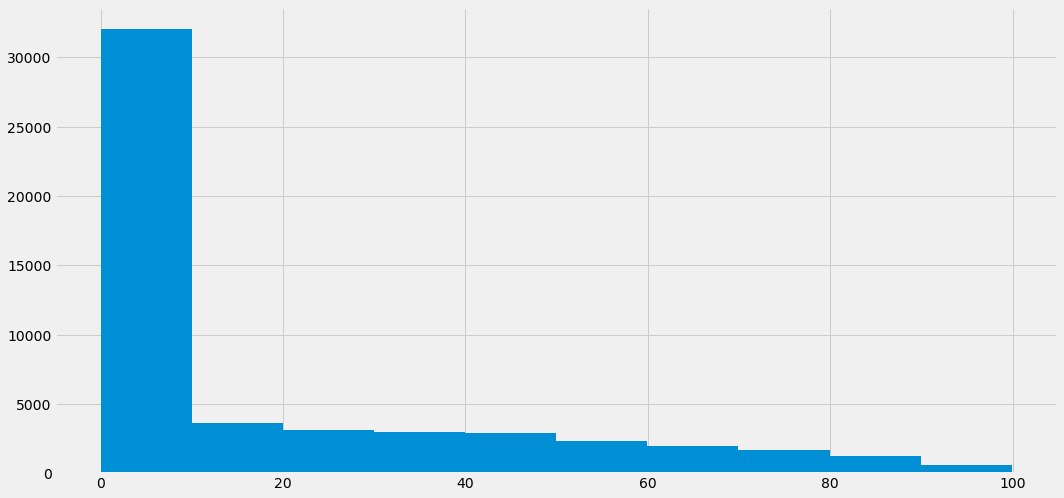

In [12]:
train['TARGET'].hist()

<AxesSubplot:>

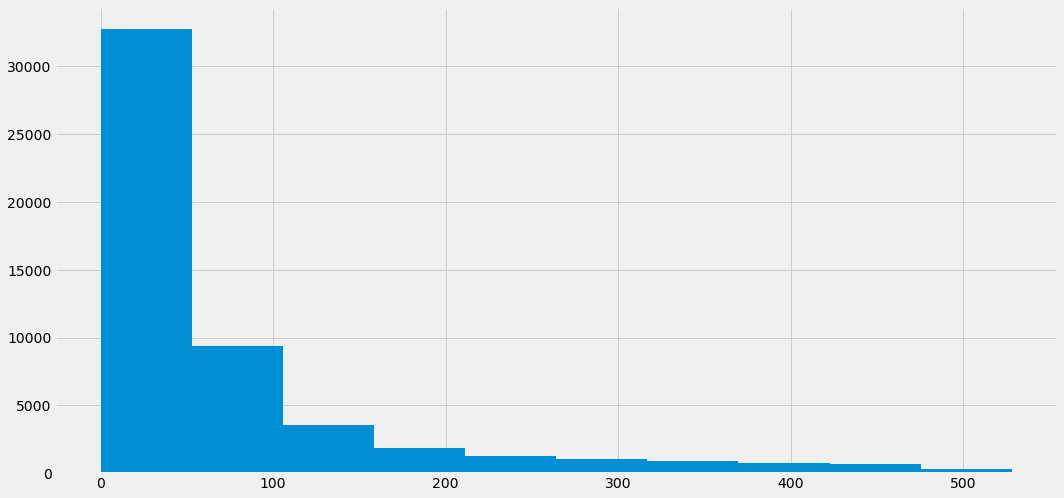

In [13]:
train['DHI'].hist()

<AxesSubplot:>

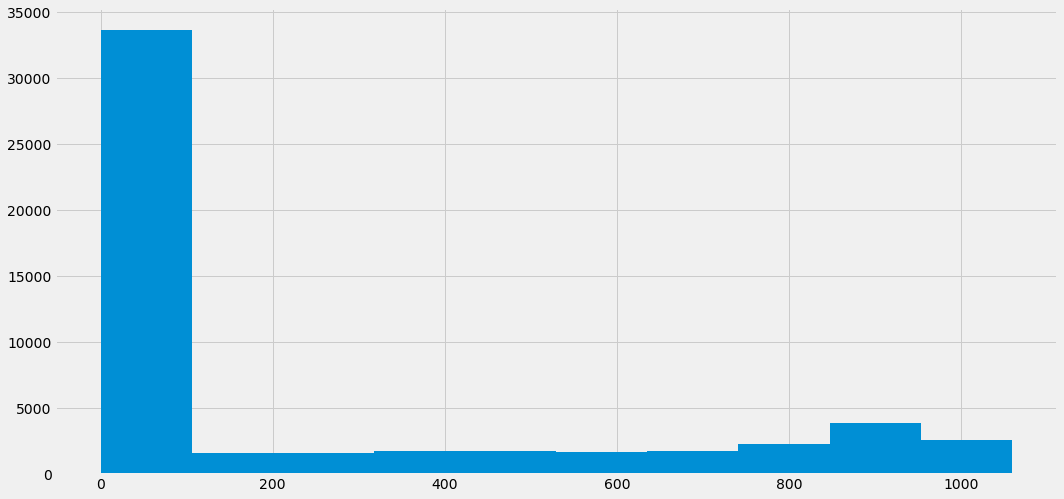

In [14]:
train['DNI'].hist()

<AxesSubplot:>

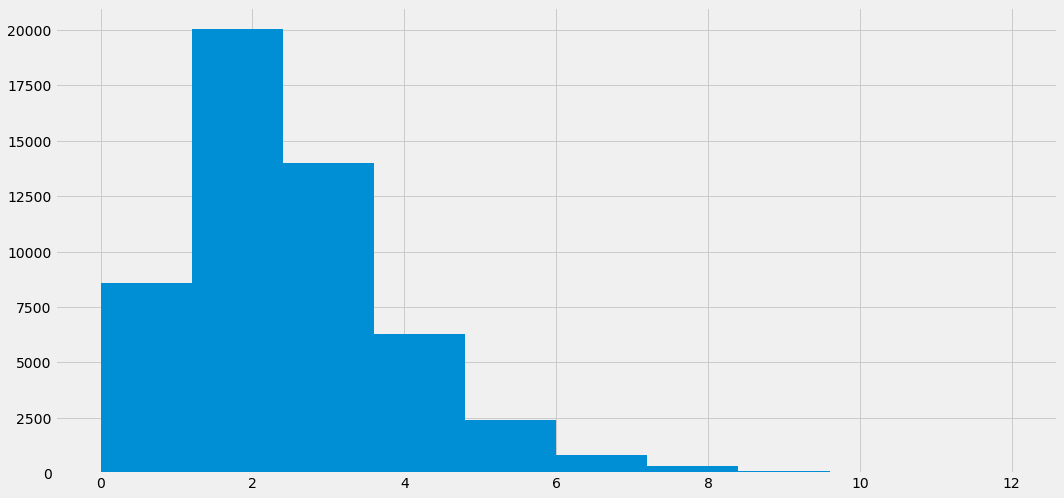

In [15]:
train['WS'].hist()

<AxesSubplot:>

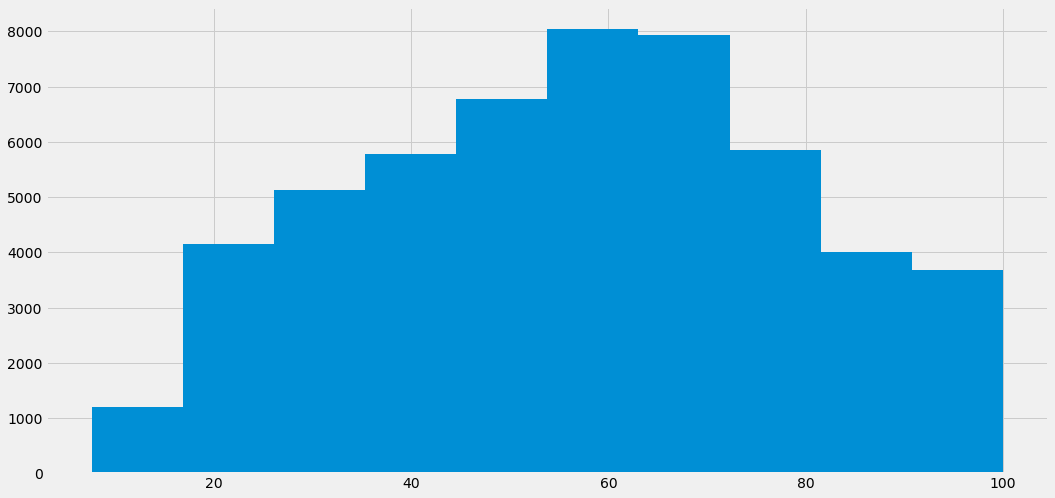

In [16]:
train['RH'].hist()

<AxesSubplot:>

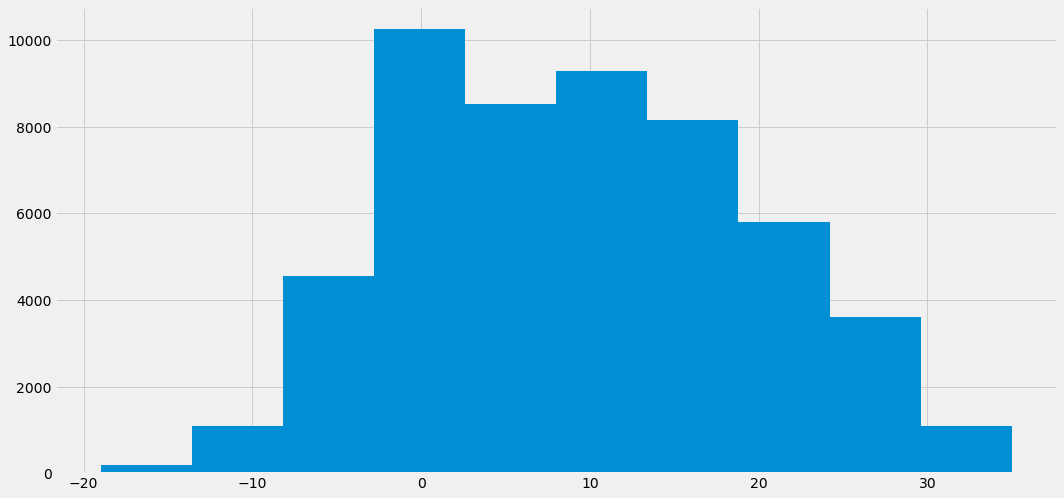

In [17]:
train['T'].hist()

In [20]:
plt.text

<function matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)>

In [24]:
train.corr().style.background_gradient()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
Day,1.0000,0.0000,0.0000,-0.0278,0.0219,0.0385,-0.1277,0.0729,-0.0025
Hour,0.0000,1.0000,0.0000,0.0299,-0.0181,-0.0559,-0.0843,0.1055,0.0038
Minute,0.0000,0.0000,1.0000,-0.0013,-0.0010,-0.0095,0.0088,-0.0076,-0.0002
DHI,-0.0278,0.0299,-0.0013,1.0000,0.2883,0.2033,-0.4785,0.4578,0.6669
DNI,0.0219,-0.0181,-0.0010,0.2883,1.0000,0.2196,-0.6112,0.4025,0.8335
WS,0.0385,-0.0559,-0.0095,0.2033,0.2196,1.0000,-0.2300,0.0277,0.2385
RH,-0.1277,-0.0843,0.0088,-0.4785,-0.6112,-0.2300,1.0000,-0.5328,-0.6772
T,0.0729,0.1055,-0.0076,0.4578,0.4025,0.0277,-0.5328,1.0000,0.5620
TARGET,-0.0025,0.0038,-0.0002,0.6669,0.8335,0.2385,-0.6772,0.5620,1.0000


## 전처리

이 부분 함수는 아마도 
- train 데이터인 경우 [Hour	TARGET_lag_48	DHI_lag_48	DNI_lag_48	WS_lag_48	RH_lag_48	T_lag_48 ]까지는 1일전 날씨와 발전량이고 	Target1	은 당일 발전량 Target2는 다음날 발전량으로 리턴하는 것으로 보임
- test 데이터인 경우 [Hour	TARGET_lag_48	DHI_lag_48	DNI_lag_48	WS_lag_48	RH_lag_48	T_lag_48 ]까지 1일전 날씨와 발전량을 리턴하는 것으로 보임 

In [26]:
def create_lag_feats(data, lags, cols):
    
    lag_cols = []
    temp = data.copy()
    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            temp['Target1'] = temp['TARGET']
            temp['Target2'] = temp['TARGET'].shift(-48).fillna(method='ffill')
            temp['GHI']=temp['DNI'].shift(48)+temp['DHI'].shift(48)
            temp['somethingnew']=temp['TARGET'].shift(48)/temp['GHI'].shift(48)
            temp['Target_mean4'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill')+ temp['TARGET'].shift(48*3).fillna(method='ffill') + temp['TARGET'].shift(48*4).fillna(method='ffill')) /4
            lag_cols.append(col + '_lag_%s'%lag)

    return temp, lag_cols
    

def preprocess_data(data, target_lags=[48], weather_lags=[48], is_train=True):
    
    temp = data.copy()

    if is_train==True:          
    
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T','GHI','somethingnew','Target_mean4'])
     
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2 + ['Target1', 'Target2']].dropna()

    elif is_train==False:    
        
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI', 'DNI', 'WS', 'RH', 'T','GHI','somethingnew','Target_mean4'])
                              
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2].dropna()




### Train 데이터 전처리

In [27]:
df_train = preprocess_data(train, target_lags=[48], weather_lags=[48], is_train=True)
df_train.iloc[:48]

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48,somethingnew_lag_48,Target_mean4_lag_48,Target1,Target2
256,8,4.5047,33.0,166.0,4.1,71.83,0.0,146.0,0.5162,4.7632,5.2554,0.7508
257,8,9.4785,63.0,220.0,4.5,66.72,1.0,225.0,0.4849,7.8133,11.0737,1.5955
258,9,4.1292,44.0,0.0,4.9,73.36,2.0,408.0,0.2833,16.4711,13.5134,4.8803
259,9,7.7891,83.0,0.0,5.7,68.23,3.0,312.0,0.3294,13.5146,21.1144,3.7540
260,10,9.1028,97.0,0.0,6.6,65.55,4.0,429.0,0.1081,25.4098,26.6507,5.4432
261,10,12.1058,129.0,0.0,7.0,65.53,4.0,188.0,0.1543,23.0868,29.8410,8.4463
262,11,25.0560,202.0,149.0,7.4,64.54,5.0,488.0,0.3696,27.8496,38.3800,12.2941
263,11,17.0794,173.0,20.0,7.7,64.51,5.0,421.0,0.2463,30.1254,40.9136,16.8924
264,12,25.8065,218.0,123.0,8.0,67.17,6.0,114.0,0.0546,24.0251,42.2274,20.9276
265,12,20.6452,198.0,48.0,7.8,67.18,6.0,158.0,0.2797,23.3213,41.8520,26.0891


In [29]:
df_train.corr().style.background_gradient()

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,GHI_lag_48,somethingnew_lag_48,Target_mean4_lag_48,Target1,Target2
Hour,1.0000,-0.0835,0.0251,-0.1613,-0.0795,-0.1092,0.1277,-0.1577,0.1200,-0.0964,-0.0835,-0.0835
TARGET_lag_48,-0.0835,1.0000,0.4108,0.6838,0.1003,-0.6063,0.4599,0.4609,-0.0183,0.7452,0.6930,0.6434
DHI_lag_48,0.0251,0.4108,1.0000,-0.2401,0.0641,-0.2300,0.2921,0.1905,-0.0005,0.5475,0.4535,0.4762
DNI_lag_48,-0.1613,0.6838,-0.2401,1.0000,0.0737,-0.4708,0.1481,0.3684,-0.0288,0.2774,0.3053,0.2358
WS_lag_48,-0.0795,0.1003,0.0641,0.0737,1.0000,-0.0522,-0.1359,0.1181,-0.0185,0.1435,0.1209,0.1052
RH_lag_48,-0.1092,-0.6063,-0.2300,-0.4708,-0.0522,1.0000,-0.5920,-0.4475,-0.0106,-0.5529,-0.4588,-0.4103
T_lag_48,0.1277,0.4599,0.2921,0.1481,-0.1359,-0.5920,1.0000,0.2462,0.0494,0.4861,0.3735,0.3526
GHI_lag_48,-0.1577,0.4609,0.1905,0.3684,0.1181,-0.4475,0.2462,1.0000,0.0359,0.5968,0.3975,0.3707
somethingnew_lag_48,0.1200,-0.0183,-0.0005,-0.0288,-0.0185,-0.0106,0.0494,0.0359,1.0000,-0.0889,-0.0219,-0.0261
Target_mean4_lag_48,-0.0964,0.7452,0.5475,0.2774,0.1435,-0.5529,0.4861,0.5968,-0.0889,1.0000,0.7244,0.7148


### TEST데이터 전처리

test 데이터는 각 데이터의 마지막 날만 가져옴  
-- 48(마지막날 데이터)*81(test데이터의 수) = 3888

In [7]:
df_test = []

for test_file in test_files:
    temp = pd.read_csv(test_file)
    temp = preprocess_data(temp, target_lags=[48], weather_lags=[48], is_train=False).iloc[-48:]
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

## 모델 학습

### 훈련세트 테스트 세트 나누기 
  0_train_1 : 1일전 날씨와 당일 발전량   
  0_train_2 : 1일전 날씨와 다음날 발전량 

### 학습

In [8]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [9]:
df_train

,Hour,TARGET_lag_48,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,Target1,Target2
48,0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0,0.0
49,0,0.0,0.0,0.0,1.5,69.06,-12.0,0.0,0.0
50,1,0.0,0.0,0.0,1.6,71.78,-12.0,0.0,0.0
51,1,0.0,0.0,0.0,1.6,71.75,-12.0,0.0,0.0
52,2,0.0,0.0,0.0,1.6,75.20,-12.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,21,0.0,0.0,0.0,2.4,68.38,-2.0,0.0,0.0
52556,22,0.0,0.0,0.0,2.4,71.09,-3.0,0.0,0.0
52557,22,0.0,0.0,0.0,2.2,71.11,-3.0,0.0,0.0
52558,23,0.0,0.0,0.0,2.1,74.99,-4.0,0.0,0.0


In [10]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

LGBM regressor 사용 

In [53]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
        # (a) Modeling  
    model = LGBMRegressor(objective='quantile',
                          alpha=q,
                          n_estimators=10000, 
                          bagging_fraction=0.7, 
                          learning_rate=0.001, 
                          num_leaves=512,
                          min_child_samples=10,
                          sub_freq=1,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train,
                  eval_metric = ['quantile'],
                  eval_set=[(X_valid, Y_valid)],
                  early_stopping_rounds=300, 
                  verbose=500)
                              

        # (b) Predictions
       
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

Target 예측

In [54]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

당일 TARGET예측

In [55]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.37212
Early stopping, best iteration is:
[676]	valid_0's quantile: 1.37108
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.16051
[1000]	valid_0's quantile: 2.14876
[1500]	valid_0's quantile: 2.14286
[2000]	valid_0's quantile: 2.13669
[2500]	valid_0's quantile: 2.13719
Early stopping, best iteration is:
[2316]	valid_0's quantile: 2.13589
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.57354
[1000]	valid_0's quantile: 2.54514
[1500]	valid_0's quantile: 2.53945
[2000]	valid_0's quantile: 2.53633
[2500]	valid_0's quantile: 2.53497
[3000]	valid_0's quantile: 2.53294
[3500]	valid_0's quantile: 2.5275
Early stopping, best iteration is:
[3505]	valid_0's quantile: 2.5274
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.6792
[1000]	valid_0's quantile: 2.65925
[1500]	va

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


다음날 Target 예측

In [28]:
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[182]	valid_0's quantile: 1.4093
0.2
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.2503
[1000]	valid_0's quantile: 2.23588
Early stopping, best iteration is:
[1173]	valid_0's quantile: 2.23198
0.3
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.66486
[1000]	valid_0's quantile: 2.64927
[1500]	valid_0's quantile: 2.63853
Early stopping, best iteration is:
[1398]	valid_0's quantile: 2.63812
0.4
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.8087
[1000]	valid_0's quantile: 2.77833
[1500]	valid_0's quantile: 2.76475
Early stopping, best iteration is:
[1651]	valid_0's quantile: 2.76252
0.5
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.72555
[1000]	valid_0's quantile: 2.6931
Early stopping, best iteration is:
[1174]	va

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [29]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values

### 결과

In [30]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


가장 잘 나왔던 파일과 비교

(0.0, 500.0)

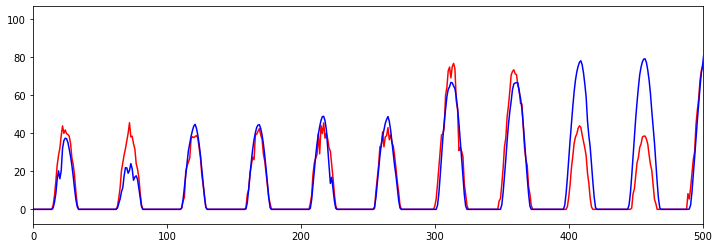

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
targetmean=pd.read_csv('/content/drive/MyDrive/data/201216-165538_KTH.csv')
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,7776),submission['q_0.5'],'r')
plt.plot(np.arange(0,7776),targetmean['q_0.5'],'b')
plt.xlim(0,500)